In [3]:
import logging
import sys
import os
import lzma
import random


import collections
#import tokenization
import tensorflow as tf

import copy
import json
import math
import re
import numpy as np
import six

def printable_text(text):
  """Returns text encoded in a way suitable for print or `tf.logging`."""

  # These functions want `str` for both Python2 and Python3, but in one case
  # it's a Unicode string and in the other it's a byte string.
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text
    elif isinstance(text, unicode):
      return text.encode("utf-8")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
      raise ValueError("Not running on Python2 or Python 3?")

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab

def convert_tokens_to_ids(tokens):
        """Converts a sequence of tokens into ids using the vocab."""
        ids = []
        for token in tokens:
            ids.append(vocab_words[token])
        return ids
    
MaskedLmInstance = collections.namedtuple("MaskedLmInstance",["index", "label"])

def create_masked_lm_predictions(tokens, masked_lm_prob,
                                 max_predictions_per_seq, vocab_words, rng):
    """Creates the predictions for the masked LM objective."""
    cand_indexes = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        cand_indexes.append(i)

    rng.shuffle(cand_indexes)

    output_tokens = list(tokens)

    num_to_predict = min(max_predictions_per_seq,
                       max(1, int(round(len(tokens) * masked_lm_prob))))

    masked_lms = []
    covered_indexes = set()
    for index in cand_indexes:
        if len(masked_lms) >= num_to_predict:
            break
        if index in covered_indexes:
            continue
        covered_indexes.add(index)

        masked_token = None
        # 80% of the time, replace with [MASK]
        if rng.random() < 0.8:
            masked_token = "[MASK]"
        else:
        # 10% of the time, keep original
            if rng.random() < 0.5:
                masked_token = tokens[index]
        # 10% of the time, replace with random word
            else:
                masked_token = vocab_words[rng.randint(0, len(vocab_words) - 1)]

        output_tokens[index] = masked_token

        masked_lms.append(MaskedLmInstance(index=index, label=tokens[index]))

    masked_lms = sorted(masked_lms, key=lambda x: x.index)
    #print(masked_lms)
    masked_lm_positions = []
    masked_lm_labels = []
    for p in masked_lms:
        masked_lm_positions.append(p.index)
        masked_lm_labels.append(p.label)

    return (output_tokens, masked_lm_positions, masked_lm_labels)


class TrainingInstance(object):
  """A single training instance (sentence pair)."""

  def __init__(self,tokens,masked_lm_positions, masked_lm_labels):
    self.tokens = tokens
    #self.segment_ids = segment_ids
    #self.is_random_next = is_random_next
    self.masked_lm_positions = masked_lm_positions
    self.masked_lm_labels = masked_lm_labels

  def __str__(self):
    s = ""
    s += "tokens: %s\n" % (" ".join(
        [printable_text(x) for x in self.tokens]))
    #s += "segment_ids: %s\n" % (" ".join([str(x) for x in self.segment_ids]))
    #s += "is_random_next: %s\n" % self.is_random_next
    s += "masked_lm_positions: %s\n" % (" ".join(
        [str(x) for x in self.masked_lm_positions]))
    s += "masked_lm_labels: %s\n" % (" ".join(
        [printable_text(x) for x in self.masked_lm_labels]))
    s += "\n"
    return s

  def __repr__(self):
    return self.__str__()

def create_int_feature(values):
  feature = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
  return feature

def create_float_feature(values):
  feature = tf.train.Feature(float_list=tf.train.FloatList(value=list(values)))
  return feature

def write_instance_to_example_files(instances, max_seq_length,
                                    max_predictions_per_seq, output_files):
  """Create TF example files from `TrainingInstance`s."""
  writers = []
  for output_file in output_files:
    writers.append(tf.python_io.TFRecordWriter(output_file))

  writer_index = 0

  total_written = 0
  for (inst_index, instance) in enumerate(instances):
    input_ids =convert_tokens_to_ids(instance.tokens)
    input_mask = [1] * len(input_ids)
    #segment_ids = list(instance.segment_ids)
    assert len(input_ids) <= max_seq_length

    while len(input_ids) < max_seq_length:
      input_ids.append(0)
      input_mask.append(0)
      #segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    #assert len(segment_ids) == max_seq_length

    masked_lm_positions = list(instance.masked_lm_positions)
    masked_lm_ids = convert_tokens_to_ids(instance.masked_lm_labels)
    masked_lm_weights = [1.0] * len(masked_lm_ids)

    while len(masked_lm_positions) < max_predictions_per_seq:
      masked_lm_positions.append(0)
      masked_lm_ids.append(0)
      masked_lm_weights.append(0.0)

    #next_sentence_label = 1 if instance.is_random_next else 0

    features = collections.OrderedDict()
    features["input_ids"] = create_int_feature(input_ids)
    features["input_mask"] = create_int_feature(input_mask)
    #features["segment_ids"] = create_int_feature(segment_ids)
    features["masked_lm_positions"] = create_int_feature(masked_lm_positions)
    features["masked_lm_ids"] = create_int_feature(masked_lm_ids)
    features["masked_lm_weights"] = create_float_feature(masked_lm_weights)
    #features["next_sentence_labels"] = create_int_feature([next_sentence_label])

    tf_example = tf.train.Example(features=tf.train.Features(feature=features))

    writers[writer_index].write(tf_example.SerializeToString())
    writer_index = (writer_index + 1) % len(writers)

    total_written += 1

    if inst_index < 20:
      tf.logging.info("*** Example ***")
      tf.logging.info("tokens: %s" % " ".join(
          [printable_text(x) for x in instance.tokens]))

      for feature_name in features.keys():
        feature = features[feature_name]
        values = []
        if feature.int64_list.value:
          values = feature.int64_list.value
        elif feature.float_list.value:
          values = feature.float_list.value
        tf.logging.info(
            "%s: %s" % (feature_name, " ".join([str(x) for x in values])))

  for writer in writers:
    writer.close()

  tf.logging.info("Wrote %d total instances", total_written)



In [8]:

data_dev=load_vocab('data/kielipankki_clean.dev')
vocab_words=load_vocab('data/vocab_with_aff')
rng=random.Random(4)
instances = []
masked_lm_prob=0.15
max_predictions_per_seq=1
temp_vocab=[]
for vocab,ind in vocab_words.items():
    temp_vocab.append(vocab)
for tok,ind in data_dev.items():
    token_tex=tok.split()
    (tokens, masked_lm_positions,
     masked_lm_labels)=create_masked_lm_predictions(token_tex,masked_lm_prob,
                                  max_predictions_per_seq,temp_vocab,rng)
    instance=TrainingInstance(tokens, masked_lm_positions,
     masked_lm_labels)
    instances.append(instance)
    
write_instance_to_example_files(instances,800,
                                max_predictions_per_seq,['kielipankki_clean_dev_output.tfrecord'])


INFO:tensorflow:*** Example ***
INFO:tensorflow:tokens: [CLS] vennamo vakuuttaa ettei hän ole tehnyt mitään väärä+ +ä ilmoitta+ +neen+ +sa osake+ +omis+ +t+ +uksista+ +an saa+ +ti lain+ +vasta+ +näissä+ [SEP]
INFO:tensorflow:input_ids: 2377 32581 31667 3978 4867 19081 27800 16927 31278 3 6623 18040 23963 19620 19327 26729 30709 1006 23973 28280 13368 32332 17809 24973 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [11]:

input_files = []



In [12]:
input_files

['./kielipankki_clean_dev_output.tfrecord']

In [14]:
data_dev=load_vocab('data/kielipankki_clean.train')

In [15]:
len(data_dev)

11667189

In [11]:
tmp=[]
max_t=0
max_ind=0
toki=''
counter=0
greaterthan=[]
for tok,ind in data_dev.items():
    tmp.append(len(tok))
    if len(tok)> max_t:
        toki=tok
        max_t=len(tok)
        max_ind=ind
    if len(tok)>500:
        counter+=1
        greaterthan.append(tok)

In [12]:
counter

44582

In [14]:
import matplotlib.pyplot as plt

In [9]:
data_dev['[CLS] vanhan s+ +laa+ +vi+ +laisen usko+ +muksen mukaan vuosituhannen viimeisen vuoden ensimmäinen sunnuntai on suuri t+ +aika+ +päivä [SEP]']

0

In [10]:
data_dev.pop(toki)

2808608

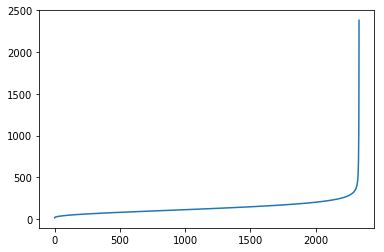

In [19]:
plt.plot(np.sort(tmp)[::5000])
plt.show()

In [29]:
percentage_over_ = [(i,np.sum(np.asarray(tmp)>i) / len(tmp)*100) for i in range(100,1000,10)]

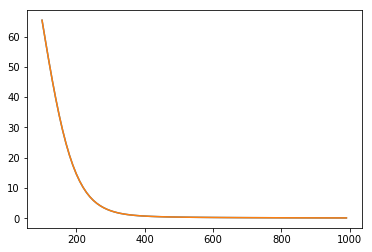

In [28]:
plt.plot(list(zip(*percentage_over_))[0],list(zip(*percentage_over_))[1])
plt.show()

In [16]:
counter=0
greaterthan=[]
for tok,ind in data_dev.items():
    if len(tok)>300:
        #data_dev.pop(tok)
        counter+=1
        greaterthan.append(tok)

In [17]:
len(greaterthan)

292340

In [18]:
counter

292340

In [19]:
for i in greaterthan:
    data_dev.pop(i)

In [20]:
len(data_dev)

11374849

In [2]:
import os

import tensorflow as tf
from tensorflow import keras

In [3]:
latest = tf.train.latest_checkpoint('outputckpoints_1306/')

In [4]:
latest

'outputckpoints_1306/model.ckpt-80000'